# Setup

In [42]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from IPython.display import display, Markdown
from tqdm import tqdm
import numpy as np
import pennylane as qml
import pygad
import cProfile

In [43]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

In [44]:
logging = True # Set to True to enable mlflow logging
profiling = False # Set to True to enable profiling

batch_size = 16 
EPOCHS = 5 # number of epochs for training. if genetic is True, this is the number of generations
seq_length = 3 # length of the sequence to be used for training lstms
LR = 0.0002 
hidden_size = 256 # size of the memories in the lstms
device = torch.device("cpu")
shuffle_train = True
prop = 0.8 # proportion of data to be used for training
type_of_model = "classical" # "classical" or "quantum"
n_qlayers = 1 # number of quantum layers in every VQC bloc in the quantum model
features = ['Open', 'High', 'Low', 'Close'] # open must be first, features to use among ['Date', 'Open', 'High', 'Low', 'Close','sine','cosine']
target = 'Close'
device_simulator = "default.qubit" # simulator to use for the quantum model. only default.qubit seem to work for me

genetic = False # if True, the model will be trained using a genetic algorithm. if False, it will be trained using backpropagation
sol_per_pop=20
num_parents_mating=10
mutation_percent_genes=10

### Logging

In [45]:
if logging :
    import mlflow
    hyperparams = {
        "batch_size": batch_size,
        "EPOCHS": EPOCHS,
        "seq_length": seq_length,
        "LR": LR,
        "hidden_size": hidden_size,
        "device": device,
        "shuffle_train": shuffle_train,
        "prop": prop,
        "seed": seed,
        "type": type_of_model,
        "n_qlayers": n_qlayers,
        "chosen_features": features,
        "device_simulator": device_simulator,
        "genetic": genetic,
        "sol_per_pop": sol_per_pop,
        "num_parents_mating": num_parents_mating,
        "mutation_percent_genes": mutation_percent_genes,
    }

    mlflow.start_run()

    mlflow.log_params(hyperparams)

# Data

The Euro to USD exchange rate data per day retrieved from [yahoo finance](https://finance.yahoo.com/)

In [46]:
ticker = "EURUSD=X"
df = yf.download(ticker, start="2003-12-01", end="2025-03-01", interval="1d")
df = pd.DataFrame(df).drop(columns=['Volume']) # only zeros
df.columns = [col[0] for col in df.columns]
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [47]:
df['Date'] = pd.to_datetime(df['Date'])

ref_date = pd.to_datetime('2000-01-01')

df['Date int'] = (df['Date'] - ref_date).dt.days

#some feature engineering
w = 2*np.pi/365.25
df['sine'] = np.sin(w*df['Date int'])
df['cosine'] = np.cos(w*df['Date int'])

df = df[['Date', 'Open', 'High', 'Low', 'Close','sine','cosine']] #just for lisibility
df.head()

,Date,Open,High,Low,Close,sine,cosine
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,-0.508356,0.861147
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,-0.493468,0.869764
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,-0.478434,0.878124
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,-0.463258,0.886224
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,-0.447945,0.894061


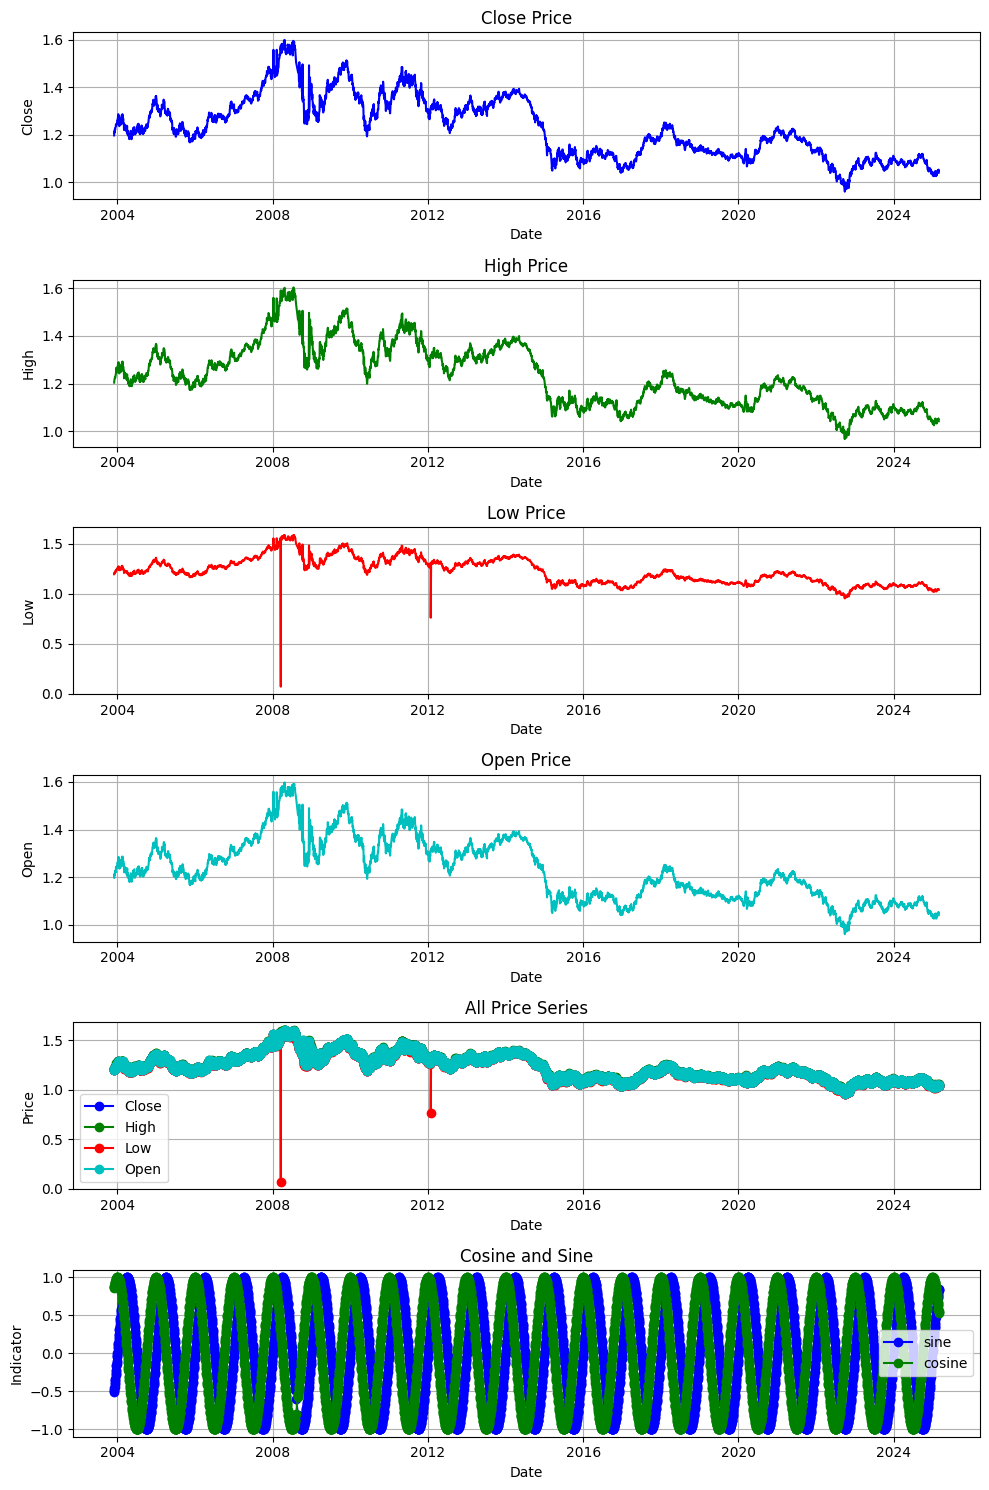

In [48]:
# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 15))

# Plot each time series
axs[0].plot(df['Date'], df['Close'], label='Close', color='b')
axs[0].set_title('Close Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close')
axs[0].grid(True)

axs[1].plot(df['Date'], df['High'], label='High', color='g')
axs[1].set_title('High Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('High')
axs[1].grid(True)

axs[2].plot(df['Date'], df['Low'], label='Low', color='r')
axs[2].set_title('Low Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Low')
axs[2].grid(True)

axs[3].plot(df['Date'], df['Open'], label='Open', color='c')
axs[3].set_title('Open Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Open')
axs[3].grid(True)

# Plot the entire dataframe for reference
axs[4].plot(df['Date'], df['Close'], label='Close', color='b', linestyle='-', marker='o')
axs[4].plot(df['Date'], df['High'], label='High', color='g', linestyle='-', marker='o')
axs[4].plot(df['Date'], df['Low'], label='Low', color='r', linestyle='-', marker='o')
axs[4].plot(df['Date'], df['Open'], label='Open', color='c', linestyle='-', marker='o')
axs[4].set_title('All Price Series')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Price')
axs[4].legend()
axs[4].grid(True)

axs[5].plot(df['Date'], df['sine'], label='sine', color='b', linestyle='-', marker='o')
axs[5].plot(df['Date'], df['cosine'], label='cosine', color='g', linestyle='-', marker='o')
axs[5].set_title('Cosine and Sine')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Indicator')
axs[5].legend()
axs[5].grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()


In [49]:
full_dataframe_size = len(df)
train_dataframe_size = int(full_dataframe_size * prop)

train_dataframe = df[:train_dataframe_size]
test_dataframe = df[train_dataframe_size-seq_length:] # we take the last seq_length of the train dataset to start testing at the start of the test dataset. 
#these seq_length values wont be infered (see SequenceDataset class)

In [50]:
class SequenceDataset(Dataset):
    """
    Dataset for time series data
    target is a float
    input is a vector of size nb_features*seq_length + 1 : it contains the features of the previous seq_length days and the open price of the current day
    """
    def __init__(self, dataframe, seq_length, target, features):
        self.dataframe = dataframe
        self.seq_length = seq_length
        self.target = target
        self.features = features

        self.x = torch.tensor(self.dataframe[self.features].values, dtype=torch.float32)
        self.y = torch.tensor(self.dataframe[self.target].values, dtype=torch.float32)

        super().__init__()

    def __len__(self):
        return len(self.dataframe) - self.seq_length
    
    def __getitem__(self, idx):
        df_idx = idx + self.seq_length # we start reading the dataframe at idx + seq_length to ensure we can always read seq_length days before the current day

        x = self.x[df_idx - self.seq_length:df_idx]
        x = x.flatten()
        opentoday = self.x[df_idx][0]
        x = torch.cat((x, opentoday.view(-1)), 0)
        y = self.y[df_idx]

        return x, y

In [51]:
train_dataset = SequenceDataset(train_dataframe, seq_length, target, features)
test_dataset = SequenceDataset(test_dataframe, seq_length, target, features)
full_dataset = SequenceDataset(df, seq_length, target, features)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train, generator=torch.Generator().manual_seed(seed) if shuffle_train else None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# Testing and plotting functions

The displayed MSE are always per batch

In [52]:
def print_mse(mse, message) :

    display(Markdown(f'# <span style="font-size: 24px;">{message} : {mse}</span>'))

In [53]:
def infer(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            
            preds = model(x)
            
            # Store predictions and labels
            y_pred.append(preds)
            y_true.append(y)
    
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    
    return y_pred, y_true

In [54]:
def plot_time_series(pred, true, start, end, title,vlinesplit=None):
    plt.plot(pred[start:end], label='Prediction', color='r')
    plt.plot(true[start:end], label='True', color='b')
    if vlinesplit is not None:
        plt.axvline(x=vlinesplit, color='g', linestyle='--', label='Testing start')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_full_time_series(pred, true, title) :
    end = len(df) - seq_length
    vlinesplit = train_dataframe_size - seq_length
    plot_time_series(pred, true, 0, end, title, vlinesplit=vlinesplit)

def plot_multiple_time_series(preds, true, start, end, title, labels, vlinesplit=None): 
    colors = ['r', 'g']
    for i in range(len(preds)):
        plt.plot(preds[i][start:end], label=labels[i], color=colors[i])
    plt.plot(true[start:end], label='True', color='b')
    if vlinesplit is not None:    
        plt.axvline(x=vlinesplit, color='g', linestyle='--', label='Testing start')
    plt.title(title)
    plt.legend()
    plt.show()


In [55]:
def plot_loss(loss_per_epoch, title, remove_first = False):
    x = range(1, len(loss_per_epoch) + 1)

    if remove_first :
        x = range(2, len(loss_per_epoch) + 1)
        loss_per_epoch = loss_per_epoch[1:]

    plt.plot(x, loss_per_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

def plot_losses(train_losses, test_losses, title, remove_first = False, train_lv_mse = None, test_lv_mse = None):
    x = range(1, len(train_losses) + 1)

    if remove_first :
        x = range(2, len(train_losses) + 1)
        train_losses = train_losses[1:]
        test_losses = test_losses[1:]

    plt.plot(x, train_losses, label='Train')
    plt.plot(x, test_losses, label='Test')

    if train_lv_mse is not None and test_lv_mse is not None:
        plt.hlines(train_lv_mse, x[0], x[-1], colors='black', linestyles='dashed', label='Train LV')
        plt.hlines(test_lv_mse, x[0], x[-1], colors='grey', linestyles='dashed', label='Test LV')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [56]:
def computeMSE(pred, true):
    mse = nn.MSELoss()
    return mse(pred, true)

# Training function

In [57]:
def train_gradient(model, train_loader, test_loader, optimizer, loss_func, EPOCHS, scheduler=None, num_params=None):
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(EPOCHS)):

        model.train()
        epoch_train_loss = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader)) # len(train_loader) is the number of batches

        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        with torch.no_grad():

            epoch_test_loss = 0

            for x, y in test_loader:
                y_pred = model(x)
                loss = loss_func(y_pred, y)
                epoch_test_loss += loss.item()
        test_losses.append(epoch_test_loss / len(test_loader))

        if epoch > 0 and logging:
            mlflow.log_metric("train_loss", train_losses[-1], step=epoch)
            mlflow.log_metric("test_loss", test_losses[-1], step=epoch)

    return train_losses, test_losses

In [58]:
def set_weights(model, weights: np.ndarray, num_classical_params = 6):
    """
    Set the weights of the model using the provided weights array.
    The first ones are for the classical part of the model, and the rest are for the quantum part.
    """
    if type_of_model == "classical":
        raise NotImplementedError("Setting weights for classical models is not implemented.")
    elif type_of_model == "quantum":
        classical_params = weights[:num_classical_params]
        quantum_params = weights[num_classical_params:]
        with torch.no_grad():
            i = 0
            for name, param in model.named_parameters():
                if not any(vqc_name in name for vqc_name in ['VQC']):
                    n = param.numel()
                    new_vals = torch.tensor(classical_params[i:i+n], dtype=param.dtype).view_as(param)
                    param[:] = new_vals
                    i += n
            assert i == len(classical_params), "Mismatch in classical parameters count."

            i = 0
            for layer_name in ['forget', 'input', 'update', 'output']:
                n = model.VQC[layer_name].weights.numel()
                new_vals = torch.tensor(quantum_params[i:i+n], dtype=model.VQC[layer_name].weights.dtype).view_as(model.VQC[layer_name].weights)
                model.VQC[layer_name].weights[:] = new_vals
                i += n
            assert i == len(quantum_params), "Mismatch in quantum parameters count."

In [59]:
def create_callback(model, loss_func, train_losses, test_losses):
    def callback(ga_instance):
        with torch.no_grad():
            best_solution, train_fitness, _ = ga_instance.best_solution()
            set_weights(model, best_solution)

            epoch_train_loss = -train_fitness
            epoch_test_loss = 0

            for x, y in test_loader:
                y_pred = model(x)
                loss = loss_func(y_pred, y)
                epoch_test_loss += loss.item()

            train_losses.append(epoch_train_loss)
            test_losses.append(epoch_test_loss / len(test_loader))

            if ga_instance.generations_completed > 0 and logging:
                mlflow.log_metric("train_loss", train_losses[-1], step=ga_instance.generations_completed)
                mlflow.log_metric("test_loss", test_losses[-1], step=ga_instance.generations_completed)

            print(f"Generation {ga_instance.generations_completed}: Train Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss / len(test_loader)}")

    return callback

def train_genetic(model, train_loader, test_loader, optimizer, loss_func, EPOCHS, scheduler=None, num_params=102):
    # epoch is the number of generations here
    train_losses = []
    test_losses = []
    with torch.no_grad():

        def fitness_func(ga_instance,solution, solution_idx):
            solution = np.array(solution)
            x,y = next(iter(train_loader))

            #set weights
            set_weights(model, solution)

            return -loss_func(model(x), y).item()
        
        callback = create_callback(model, loss_func, train_losses, test_losses)
        
        ga = pygad.GA(num_generations=EPOCHS,
              num_parents_mating=num_parents_mating,
              fitness_func=fitness_func,
              sol_per_pop=sol_per_pop,
              num_genes=num_params,  # total number of params
              gene_type=float,
              mutation_percent_genes=mutation_percent_genes,
              on_generation=callback)
            
        ga.run()

        return train_losses, test_losses
            

In [60]:
if genetic:
    train = train_genetic
else:
    train = train_gradient

# Models definition

### Last value

In [61]:
class LastValue(nn.Module):
    def forward(self, x):
        return x[:, -2] # -1 is the open of today, -2 is the close of yesterday

In [62]:
last_value = LastValue()

pred_lv_test, true_lv_test = infer(last_value, test_loader)
pred_lv_train, true_lv_train = infer(last_value, train_loader)

test_lv_mse = computeMSE(pred_lv_test, true_lv_test)
train_lv_mse = computeMSE(pred_lv_train, true_lv_train)

print_mse(train_lv_mse, "Last value train MSE")
print_mse(test_lv_mse, "Last value test MSE")

# <span style="font-size: 24px;">Last value train MSE : 0.00010077345359604806</span>

# <span style="font-size: 24px;">Last value test MSE : 2.503290852473583e-05</span>

### LSTM

In [63]:
class ClassicalLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.state_gate = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hc):
        """
        x shape : (batch_size, input_size)
        h shape : (batch_size, hidden_size)
        c shape : (batch_size, hidden_size)
        """
        h, c = hc
        xh = torch.cat((x, h), 1)

        input_value = torch.sigmoid(self.input_gate(xh))
        forget_value = torch.sigmoid(self.forget_gate(xh))
        output_value = torch.sigmoid(self.output_gate(xh))
        state_value = torch.tanh(self.state_gate(xh))

        newc = forget_value * c + input_value * state_value
        newh = output_value * torch.tanh(newc)

        return newh, newc # newh shape : (batch_size, hidden_size), newc shape : (batch_size, hidden_size)
    
class ClassicalLSTM(nn.Module):
    def __init__(self, num_features, hidden_size, device, seq_length):
        super().__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.device = device
        self.seq_length = seq_length
        
        self.cell = ClassicalLSTMCell(self.num_features, hidden_size)
        self.finalLinear = nn.Linear(hidden_size + 1, 1)

    def forward(self, x): # x shape : (batch_size, seq_length*num_features+1)
        opentoday = x[:, -1] # opentoday shape : (batch_size, 1)
        opentoday = opentoday.reshape(-1, 1)

        x = x[:, :-1] # x shape : (batch_size, seq_length*num_features)
        x = x.reshape(-1, self.seq_length, self.num_features) # x shape : (batch_size, seq_length, num_features)

        batch_size = x.size(0)

        h = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32, device=self.device)
        c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32, device=self.device)

        for i in range(self.seq_length):
            h, c = self.cell(x[:,i,:], (h, c)) # h shape : (batch_size, hidden_size), c shape : (batch_size, hidden_size)

        a = torch.cat((h, opentoday), 1) # a shape : (batch_size, hidden_size + 1)
        a = self.finalLinear(a) # a shape : (batch_size, 1)
        return a.flatten()

### QLSTM

The paper says to do 6 quantum gates, but the github decides to stick with the classical LSTM structure and replace linears gates with quantum gates (so 4 quantum gates). I will go for 4 as well for now.

In [64]:
class QuantumLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length, n_qlayers, backend = 'default.qubit'):
        super().__init__()
        self.input_size = input_size
        self.num_features = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.concat_size = input_size + hidden_size
        self.n_qubits = self.concat_size
        self.n_qlayers = n_qlayers
        self.backend = backend

        self.finalLinear = nn.Linear(self.hidden_size + 1, 1)

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def ansatz(params, wires_type):
            # Entangling layer.
            for i in range(1,self.n_qubits-1): 
                for j in range(self.n_qubits):
                    if j + i < self.n_qubits:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i]])
                    else:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i - self.n_qubits]])

            # Variational layer.
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=wires_type[i])
                qml.RY(params[1][i], wires=wires_type[i])
                qml.RZ(params[2][i], wires=wires_type[i])
                
        def VQC(features, weights, wires_type): # feature shape : (batch_size, input_size)
            ry_params = [torch.arctan(feature) for feature in features]
            rz_params = [torch.arctan(feature**2) for feature in features]
            for i in range(self.n_qubits):
                qml.Hadamard(wires=wires_type[i])
                qml.RY(ry_params[i], wires=wires_type[i])
                qml.RZ(rz_params[i], wires=wires_type[i])
        
            #Variational block.
            qml.layer(ansatz, self.n_qlayers, weights, wires_type = wires_type)

        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=self.wires_forget[i])) for i in range(self.hidden_size)]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=self.wires_input[i])) for i in range(self.hidden_size)]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=self.wires_update[i])) for i in range(self.hidden_size)]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=self.wires_output[i])) for i in range(self.hidden_size)]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, 3, self.n_qubits)} # 3 is the number of rotation gates in the ansatz (ficed to 3 : RX, RY, RZ)

        self.VQC = { # Those take an input of shape (n_qubits,) and return something of shape (hidden_size,) with hidden_size < n_qubits = hidden_size + num_features
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }

    def forward(self, x):
        opentoday = x[:, -1] # opentoday shape : (batch_size, 1)
        opentoday = opentoday.reshape(-1, 1)

        x = x[:, :-1] # x shape : (batch_size, seq_length*num_features)
        x = x.reshape(-1, self.seq_length, self.num_features) # x shape : (batch_size, seq_length, num_features)

        batch_size = x.size(0)

        device = x.device
        h = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32, device=device)
        c = torch.zeros(batch_size, self.hidden_size, dtype=torch.float32, device=device)

        for i in range(self.seq_length):
            # apply one qlstm cell
            xh = torch.cat((x[:,i,:], h), 1) # xh shape : (batch_size, concat_size)

            input_value = torch.vmap(self.VQC['input'])(xh)
            forget_value = torch.vmap(self.VQC['forget'])(xh)
            output_value = torch.vmap(self.VQC['output'])(xh)
            update_value = torch.vmap(self.VQC['update'])(xh)
            input_value = torch.sigmoid(input_value)
            forget_value = torch.sigmoid(forget_value)
            output_value = torch.sigmoid(output_value)
            update_value = torch.tanh(update_value)
            # shape of each value : (batch_size, hidden_size)

            newc = forget_value * c + input_value * update_value
            newh = output_value * torch.tanh(newc)

            h, c = newh, newc # h shape : (batch_size, hidden_size), c shape : (batch_size, hidden_size)

        a = torch.cat((h, opentoday), 1) # a shape : (batch_size, hidden_size + 1)
        a = self.finalLinear(a)
        return a.flatten()  

In [65]:
num_features = len(features)

if type_of_model == "classical":
    lstm = ClassicalLSTM(num_features, hidden_size, device, seq_length)
elif type_of_model == "quantum":
    lstm = QuantumLSTM(num_features, hidden_size, seq_length, n_qlayers, backend = device_simulator)
else :
    raise ValueError("type_of_model must be 'classical' or 'quantum'")

x, y = next(iter(train_loader))

print(x.shape)
print(y.shape)

pred = lstm(x)
print(pred.shape)

torch.Size([16, 13])
torch.Size([16])
torch.Size([16])


In [66]:
def count_parameters(model):
    if type_of_model == "classical":
        return sum(p.numel() for p in model.parameters() if p.requires_grad), 0
    elif type_of_model == "quantum":
        # 1. Count ONLY classical parameters (exclude quantum weights)
        classical_params = 0
        for name, param in model.named_parameters():
            if not any(vqc_name in name for vqc_name in ['VQC']):  # Skip quantum params
                classical_params += param.numel()
        
        # 2. Count quantum parameters (VQC layers)
        quantum_params = 0
        for layer_name in ['forget', 'input', 'update', 'output']:
            quantum_params += model.VQC[layer_name].weights.numel()  # Direct tensor access
        
        return classical_params, quantum_params
    
print("Number of parameters : ", count_parameters(lstm))

Number of parameters :  (267522, 0)


In [67]:
classical_params, quantum_params = count_parameters(lstm)
num_params = classical_params + quantum_params

# Training

In [68]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_func = nn.MSELoss()

In [69]:
pred, true = infer(lstm, test_loader)
mse = computeMSE(pred, true)

print_mse(mse, "Test MSE before training")

# <span style="font-size: 24px;">Test MSE before training : 1.1035819053649902</span>

In [70]:
if profiling:
    cProfile.run('train(lstm, train_loader, test_loader, optimizer, loss_func, EPOCHS, scheduler=None, num_params = num_params)', 'profile.prof')
else:
    train_losses, test_losses = train(lstm, train_loader, test_loader, optimizer, loss_func, EPOCHS, scheduler=None, num_params = num_params)

100%|██████████| 5/5 [00:38<00:00,  7.63s/it]


In [71]:
pred_test, true_test = infer(lstm, test_loader)
mse = computeMSE(pred_test, true_test)

pred_train, true_train = infer(lstm, train_loader)
mse_train = computeMSE(pred_train, true_train)

print_mse(mse_train, "Train MSE after training")
print_mse(mse, "Test MSE after training")

# <span style="font-size: 24px;">Train MSE after training : 0.00014628414646722376</span>

# <span style="font-size: 24px;">Test MSE after training : 3.728177034645341e-05</span>

In [ ]:
pred, true = infer(lstm, full_loader)

plot_full_time_series(pred, true, "Result")

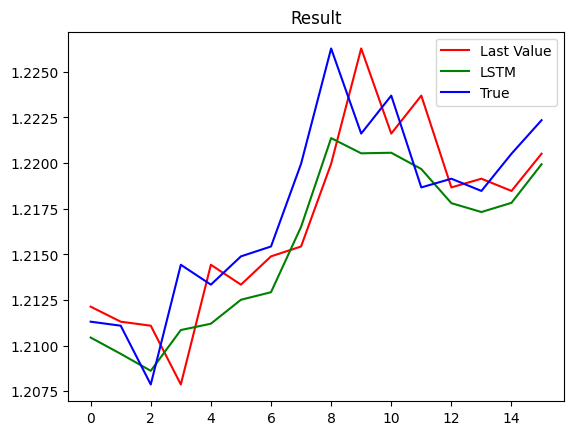

In [ ]:
plot_multiple_time_series([pred_lv_test, pred_test], true_test, 0, 16, "Result", ["Last Value", "LSTM"])

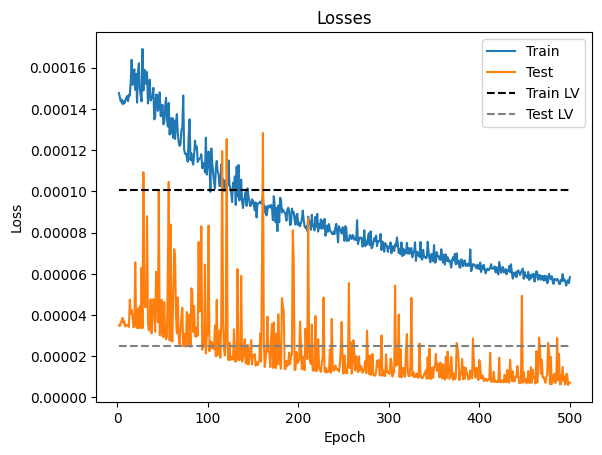

In [ ]:
plot_losses(train_losses, test_losses, "Losses", remove_first=True, train_lv_mse=train_lv_mse, test_lv_mse=test_lv_mse)

In [ ]:
if logging :
    mlflow.end_run()